# Channel network and REW delineation 

In this notebook, we'll cover the steps required to extract the REW channel network. This tutorial is specific to GRASS 7.0 and the Mac operating system (OS X). We have been most succesful with and recommend installing the GRASS 7.0.x files maintained by Michael Barton, which can be found [here](https://grass.osgeo.org/download/software/mac-osx/). Newer versions of GRASS (`7.3.x`) exist, but have not been tested for this tutorial. NOTE: For newer versions of OS X (El Capitan and on), users may need to implement [this](http://grassmac.wikidot.com) fix to get GRASS to run sucesfully. 

In [1]:
%matplotlib inline
from matplotlib import pylab
import os
import sys
from os.path import dirname
import pickle
import gdal
import fiona
import glob
import shapely
from shapely import geometry,ops
import numpy as np
import fiona
import shapely
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import geopandas as gp
import seaborn
import pyproj
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
from vadoseZone import LaioVadoseZone, PorporatoVadoseZone
from groundwaterZone import GroundwaterZone, NonlinearReservoir, NonlinearReservoir, TwoLinearReservoir, TwoParallelLinearReservoir

## Re-project DEM

First, we would like to make sure that our DEM is re-projected to match the projection of the raster files containing the forcing data. This step is not necessary depending on your method for extracting forcing data. In the [Using GDAL](), we overview a projection-independent method for generating the necessary forcing dataset that uses the command line [GDAL](http://www.gdal.org/index.html) framework. 

Here, we specify an arbitrary [PRISM](http://www.prism.oregonstate.edu) raster and re-project our watershed DEM to match this projection. The resulting DEM is stored as `dem.tif` in the `/raw_data/dem` folder of the model directory. First, let's make sure we can use GDAL. 

In [2]:
%%bash
#Make sure the following environement variables are set before attempting to re-project the dem
#these lines of code can be added to .bash_profile in your home folder. 
export PATH=/Library/Frameworks/GDAL.framework/Programs:$PATH
export PROJSO=/Library/Frameworks/PROJ.framework/PROJ

gdalinfo ../../raw_data/ppt/2012/PRISM_ppt_stable_4kmD2_20120101_bil.bil

Driver: EHdr/ESRI .hdr Labelled
Files: ../../raw_data/ppt/2012/PRISM_ppt_stable_4kmD2_20120101_bil.bil
       ../../raw_data/ppt/2012/PRISM_ppt_stable_4kmD2_20120101_bil.bil.aux.xml
       ../../raw_data/ppt/2012/PRISM_ppt_stable_4kmD2_20120101_bil.hdr
       ../../raw_data/ppt/2012/PRISM_ppt_stable_4kmD2_20120101_bil.stx
       ../../raw_data/ppt/2012/PRISM_ppt_stable_4kmD2_20120101_bil.prj
Size is 1405, 621
Coordinate System is:
GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS_1980",6378137.0,298.257222101]],
    PRIMEM["Greenwich",0.0],
    UNIT["Degree",0.0174532925199433]]
Origin = (-125.020833333333329,49.937500000002032)
Pixel Size = (0.041666666666670,-0.041666666666670)
Corner Coordinates:
Upper Left  (-125.0208333,  49.9375000) (125d 1'15.00"W, 49d56'15.00"N)
Lower Left  (-125.0208333,  24.0625000) (125d 1'15.00"W, 24d 3'45.00"N)
Upper Right ( -66.4791667,  49.9375000) ( 66d28'45.00"W, 49d56'15.00"N)
Lower Right ( -66.4791667,  24.0625000) ( 66d28'

There is a lot of information here, but what we only need the string specifying the coordinate system; that is, the bit following `Coordinate System is:`. Using the command gdalwarp, we can re-project our dem file to match the projection of the forcing data. 

In [3]:
%%bash
# Export again, otherwise GDAL won't be able to access projections list. Don't know why this must be repeated. 
export PROJSO=/Library/Frameworks/PROJ.framework/PROJ
    
gdalwarp -t_srs "GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS_1980",6378137.0,298.257222101]],
    PRIMEM["Greenwich",0.0],
    UNIT["Degree",0.0174532925199433]]" ../../raw_data/dem.tif ../../raw_data/dem.tif

Processing input file ../../raw_data/dem.tif.
Using internal nodata values (e.g. -1.7e+308) for image ../../raw_data/dem.tif.
Copying nodata values from source ../../raw_data/dem.tif to destination ../../raw_data/dem.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


## Extracting the REWs

At this point, we're ready to perform our network extraction analysis on the dem. We will do all of this operating GRASS from a BASH command line. The particulars here are a bit messy, but essentially we create a temporary workspace for GRASS, open the DEM, perform the extraction, then close everything and cleanup. The main script used for extracting the network can be found in `1_data_preparation/extract_stream_basins_topology.sh`.

In [4]:
%%bash

# make the script executable for GRASS 
chmod u+x ../1_data_preparation/extract_stream_basins_topology.sh

# create folder to store temporary grass location
DBASE=../../grassdata
mkdir $DBASE

# setup GRASS setup file to find database. This step is necessary when using GRASS from the command line. 
echo "LOCATION_NAME: 
GISDBASE:$DBASE
MAPSET: 
GUI: 
PID:" > $HOME/.grass7/rc

# create new temporary location for the job, exit after creation of this location
/Applications/GRASS-7.0.app/Contents/MacOS/grass.sh -text -c ../../raw_data/dem/dem.tif ../../grassdata/mylocation
 

Rebuilding Addon HTML manual pages index...
Rebuilding Addon menu...
Python 2.7.10 found.


Cleaning up temporary files...
Creating new GRASS GIS location/mapset...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \ 
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ / 
       \____/_/ |_/_/  |_/____/____/   \____/___//____/  

Welcome to GRASS GIS 7.0.4
GRASS GIS homepage:                      http://grass.osgeo.org
This version running through:            Bash Shell (bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

Cleaning up temporary files...
Done.

Goodbye from GRASS GIS



In [5]:
%%bash

# define the job file as environmental variable
export GRASS_BATCH_JOB="../1_data_preparation/extract_stream_basins_topology.sh"

# define channel head formation threshold
export THRESH=20000

# must set path to model folder for .sh script so it can find necessary files and store output
export MODEL=../../
 
# now we can use the temp location and run the job defined via GRASS_BATCH_JOB
/Applications/GRASS-7.0.app/Contents/MacOS/grass.sh ../../grassdata/mylocation/PERMANENT
 
# CLEANUP
unset GRASS_BATCH_JOB
 
# delete temporary location
rm -rf ../../grassdata/

# clear out rc file so that the GRASS GUI opens properly on next opening
echo "LOCATION_NAME: 
GISDBASE:
MAPSET: 
GUI: 
PID:" > $HOME/.grass7/rc

Rebuilding Addon HTML manual pages index...
Rebuilding Addon menu...
Python 2.7.10 found.
projection: 3 (Latitude-Longitude)
zone:       0
datum:      nad83
ellipsoid:  grs80
north:      39:44:04.999996N
south:      39:41:10.999997N
west:       123:38:53.000002W
east:       123:34:16.666669W
nsres:      0:00:00.333333
ewres:      0:00:00.333333
rows:       522
cols:       829
cells:      432738


Cleaning up temporary files...
Starting GRASS GIS...
Executing '../1_data_preparation/extract_stream_basins_topology.sh' ...
Proceeding with import of 1 raster bands...
Importing raster map <dem>...
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0%   4%   8%  12%  16%  20%  24%  28%  32%  36%  40%  44%  48%  52%  56%  60%  64%  68%  72%  76%  80%  84%  88%  92%  96% 100%
SECTION 2: A* Search.
   0%   2%   4%   6%   8%  10%  12%  14%  16%

Watershed with REW sub-basins. 
All stream network information is stored in rew_config 
e.g. Streams 10 and 4 feed into stream 2


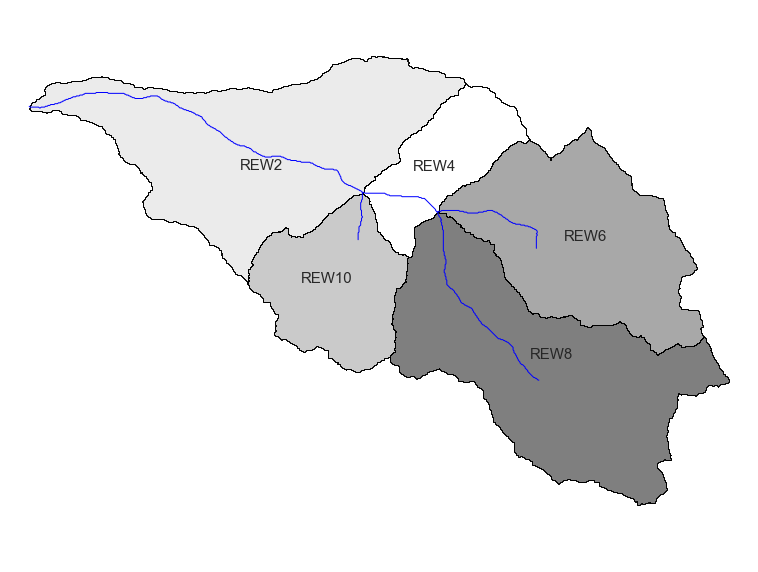

In [6]:
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
pylab.rcParams['figure.figsize'] = (20,10)

basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
basins_shape = gp.GeoDataFrame.from_file(basins)
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]

ax1 = basins_shape.plot()
for idx, row in basins_shape.iterrows():
    to_print='REW'+str(row['cat'])
    plt.annotate(s=to_print, xy=row['coords'],
                 horizontalalignment='center',fontsize=15)

streams = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
streams_shape = gp.GeoDataFrame.from_file(streams)
streams_shape.plot(ax=ax1,color='blue')

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.patch.set_facecolor('white')
prev_str01 = str(rew_config.prev_str01.loc[2])
prev_str02 = str(rew_config.prev_str02.loc[2])
title_str = 'Watershed with REW sub-basins. \nAll stream network information is stored in rew_config \n'
title_str += ("e.g. Streams %s and %s feed into stream %s" % (prev_str01,prev_str02,'2'))
print title_str